## Clustering in dodatna analiza besedila

Naslednji korak je bilo clustriranje. Glede na prve poskuse, sva ponovno določila nabor stop words, ki sva jih izločila iz predprocesirane vsebine mailov. 

Zaradi spominske zahtevnosti sva namesto klasične PCA izvedla IPCA. Tako sva uspela podatke pripraviti za vizualizacijo - to je bila edina rešitev, ki sva ji našla za vizualizacijo clustrov.

Vizualizirala sva tudi razpršenost mailov glede na kategorijo, ki ji pripada. Tako sva lahko uspešno primerjala predlagano clustriranje in razporeditev glede na dodeljene kategorije, kar je služilo za analizo potencialnega združevanja kategorij.

Predlagane clustre oziroma maile glede na cluster sva razdelila na učno in testno množico in jih pognala skozi enake modele, kot to počneva s kategorijskimi oznakami. Pričakovano je bila klasifikacijska točnost zelo visoka. 

In [1]:
import pandas as pd
import os
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.corpus import stopwords
import re
import string

import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle

import logging
from numpy import random
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier


In [2]:
df = pd.read_csv ("after_klasla.csv")

In [3]:
df

,class,content,tokenized
0,Asistenca,"Obveščamo vas, da je od kreiranja primera CUDV...","['kreiranje', 'primer', 'cudv', 'črn', 'korošk..."
1,Asistenca,"Obveščamo vas, da je od kreiranja primera DAVI...","['kreiranje', 'primer', 'seč', 'vprašanje', 'p..."
2,Asistenca,vv\n\nOd: arc@assist-austria.com <arc@assist-a...,"['poslan', 'četrtek', 'januar', 'zadevati', 'e..."
3,Asistenca,"Obveščamo vas, da je od kreiranja primera ALEŠ...","['kreiranje', 'primer', 'ruter', 'vprašanje', ..."
4,Asistenca,"Obveščamo vas, da je od kreiranja primera SUMM...","['kreiranje', 'primer', 'leasing', 'vprašanje'..."
...,...,...,...
35693,Življenje,"<html><head>_x000D_\n<meta http-equiv=""Content...","['zanimati', 'možnost', 'dobiti', 'izplačan', ..."
35694,Življenje,"<html><head>_x000D_\n<meta http-equiv=""Content...","['zanimati', 'kdaj', 'poteči', 'zavarovalen', ..."
35695,Življenje,Pozdravljeni\nProsim za podatek kdaj lahko dob...,"['podatek', 'kdaj', 'dobiti', 'izplačan', 'sre..."
35696,Življenje,"Pozdravljeni,\n\ndo 31.12. mi je moj prejšnji ...","['prejšnji', 'delodajalec', 'vplačevati', 'skl..."


In [4]:
df['tokenized'] = df['tokenized'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
df['tokenized'] = df['tokenized'].apply(lambda x: " ".join(x.split()))

In [5]:
def remove_stopwords(df):

    
    dodatne = [
 'company','underline','cambria','filtered','msochpdefault','vlink','math','potnislog','informacija',
 'zavarovalnica','cesta','ftwitter','received','contain','immediately','received','reg','environment',
 'iso','contain','ulica','environment','stran','dg',"imeti","podatek","ime","priimek","...","prejeti",
 "sporočilo","čas", "primer","nov","iso","roman","times","math","vlink","filtered","msochpdefault",
 "msonormaltable","collapse","black", "underline", "naslovznak","bold", "msohyperlink","underline", 
 "visited","purple","barbara","lorger", "wrap","windows", "cambria","weight", "bold","blue","slika", 
 "attachment","break", "emailquot","plaintext", "converted", "explore", "ftags", "disclosure", "distribution", 
 "gebrüder", "weiss","commercial", "register","terms", "conditions", "general", "assetspartnerid","lifepartnerid",
 "healthpartnerid","min","impresum"]
    
    #REMOVE STOPWORDS 
    df['tokenized'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in (dodatne)]))
    
    
    return df

In [6]:
df = remove_stopwords(df)

# Clustering

In [7]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(
                        max_df=0.75, 
                        max_features=100000,
                        min_df=0.02, 
                        use_idf=True,
                        ngram_range=(1,1))

# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
vectors = vectorizer.fit_transform(df['tokenized'])

from sklearn.cluster import KMeans


num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, max_iter=500, random_state=42)
kmeans.fit(vectors)
clusters = kmeans.labels_

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(vectors.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))# for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(15)


Cluster 0
podpis,deloven,nalog,underlina,račun,škoden,dokumentacija,potrditev,obrazec,zahtevek,prijava,škoda,priponka,priloga,pošiljati

Cluster 1
fzavarovalnica,obvestilo,oseba,elektronski,podpis,matičen,okrožen,osnoven,pravica,kapital,sodišče,ljubljana,pridržan,dokumentacija,zavarovalen

Cluster 2
prevoz,gsm,nadomesten,pošiljati,cenitev,dan,datum,poslati,priloga,strošek,najem,avtovleka,popravek,vozilo,kalkulacija

Cluster 3
prositi,server,pošta,leto,račun,zavarovanje,sklenjen,zavarovalen,polica,dan,poslati,stranka,odgovor,številka,zanimati

Cluster 4
preveriti,omejitev,pravilno,težava,danes,uporaba,napaka,mesec,telefon,koda,popust,cdrajv,aplikacija,vožnja,drajv

Cluster 5
izjava,možen,kratek,january,zdravstven,strokoven,podpora,služba,stranka,posredovati,oseben,prijava,sprememba,oznaka,obrazec

Cluster 6
varstvo,vsebovati,contents,zaupen,prepovedan,strictly,razkritje,privileged,kopiranje,namenjen,obvestiti,naslovnik,use,vsebina,pošiljatelj

Cluster 7
pomotoma,priloga,pošiljati,servi

In [8]:
from sklearn.decomposition import PCA, IncrementalPCA

# initialize PCA with 2 components
#pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
#pca_vecs = pca.fit_transform(vectors.toarray())

n_components = 2
ipca = IncrementalPCA(n_components=n_components)
ipca_vecs = ipca.fit_transform(vectors.toarray())
# save our two dimensions into x0 and x1
x0 = ipca_vecs[:, 0]
x1 = ipca_vecs[:, 1]

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

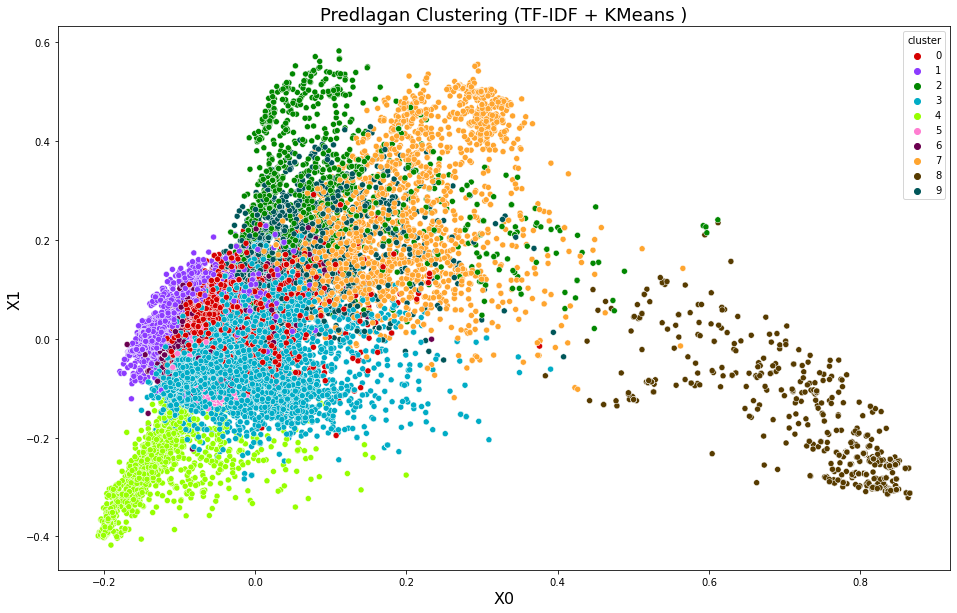

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

# set image size
plt.figure(figsize=(16, 10))
# set a title
plt.title("Predlagan Clustering (TF-IDF + KMeans )", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette=sns.color_palette(cc.glasbey, n_colors=num_clusters), legend = "full")
plt.savefig("cluster.jpg", dpi=200, bbox_inches='tight')

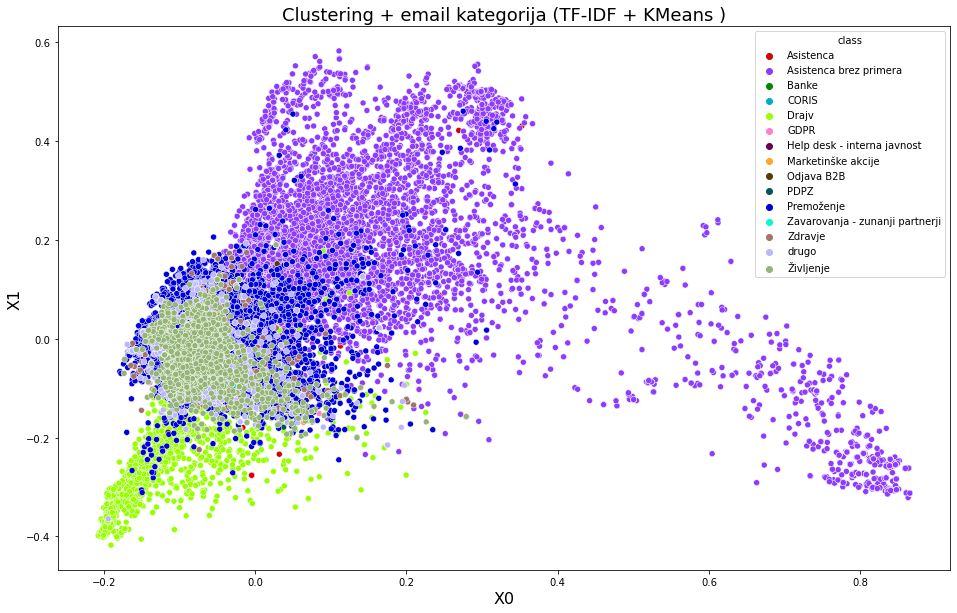

In [10]:
plt.figure(figsize=(16, 10))
# set a title
plt.title("Clustering + email kategorija (TF-IDF + KMeans )", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='class', palette=sns.color_palette(cc.glasbey, n_colors=15), legend = "full")
plt.savefig("cluster_kategorija.jpg", dpi=200, bbox_inches='tight')

In [11]:
print(df['class'].value_counts())

Premoženje                         15432
Asistenca brez primera             10280
Življenje                           2937
Drajv                               2908
drugo                               1919
Zdravje                              966
PDPZ                                 516
Odjava B2B                           331
Asistenca                            277
Marketinške akcije                    53
GDPR                                  43
Banke                                 17
CORIS                                 12
Zavarovanja - zunanji partnerji        5
Help desk - interna javnost            2
Name: class, dtype: int64


In [12]:
print(df['cluster'].value_counts())

3    16103
6     3178
0     3062
1     2565
7     2425
9     2340
4     2127
2     1695
8     1430
5      773
Name: cluster, dtype: int64


In [13]:
#NASTAVITEV PARAMETROV

#working dataframe --> pp_df (pre-processed dataframe)

my_tags= ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

X = df["tokenized"]
y = df["cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [14]:
#dummyclassifier

strategies = ['most_frequent', 'stratified', 'uniform', 'constant' ]

test_scores = []
for s in strategies:
	if s =='constant':
		dclf = DummyClassifier(strategy = s, random_state = 0, constant = 9)
	else:
		dclf = DummyClassifier(strategy = s, random_state = 0)
	dclf.fit(X_train, y_train)
	score = dclf.score(X_test, y_test)
	test_scores.append(score)
    
test_scores

[0.4549698667345726,
 0.23605805958747136,
 0.10160427807486631,
 0.06485018249724132]

In [15]:
%%time

#NAIVE BAYES


from time import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7312622018504371
              precision    recall  f1-score   support

           0       0.99      0.10      0.18      1024
           1       0.99      0.68      0.81       852
           2       0.92      0.49      0.64       586
           3       0.64      1.00      0.78      5360
           4       0.99      0.34      0.50       673
           5       1.00      0.09      0.17       244
           6       0.93      0.85      0.89      1015
           7       0.86      0.49      0.62       812
           8       0.96      0.97      0.96       451
           9       0.96      0.48      0.64       764

    accuracy                           0.73     11781
   macro avg       0.93      0.55      0.62     11781
weighted avg       0.81      0.73      0.69     11781

CPU times: user 2.73 s, sys: 144 ms, total: 2.88 s
Wall time: 3.34 s


In [16]:
%%time
#LINEAR SUPPORT VECTOR


from sklearn.linear_model import SGDClassifier


sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=45, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9447415329768271
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1024
           1       0.97      0.98      0.98       852
           2       0.95      0.96      0.96       586
           3       0.94      0.97      0.95      5360
           4       0.95      0.96      0.95       673
           5       0.99      0.86      0.92       244
           6       0.96      0.97      0.96      1015
           7       0.94      0.88      0.91       812
           8       0.99      1.00      1.00       451
           9       0.93      0.86      0.89       764

    accuracy                           0.94     11781
   macro avg       0.96      0.93      0.94     11781
weighted avg       0.94      0.94      0.94     11781

CPU times: user 2.84 s, sys: 75.7 ms, total: 2.91 s
Wall time: 2.46 s


In [17]:
%%time

#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, C=10,solver='lbfgs', max_iter=100,
                                          )),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9586622527798998
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1024
           1       0.99      0.98      0.98       852
           2       0.98      0.97      0.98       586
           3       0.95      0.98      0.96      5360
           4       0.96      0.95      0.96       673
           5       0.99      0.91      0.94       244
           6       0.97      0.97      0.97      1015
           7       0.94      0.92      0.93       812
           8       1.00      1.00      1.00       451
           9       0.95      0.91      0.93       764

    accuracy                           0.96     11781
   macro avg       0.97      0.95      0.96     11781
weighted avg       0.96      0.96      0.96     11781

CPU times: user 2.21 s, sys: 200 ms, total: 2.41 s
Wall time: 26.9 s
